In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import collections
from bitstring import BitArray

In [2]:
def test1(x):
    return 100*(x[0]**2 - x[1])**2 + (1-x[0])**2
    
def rastrigin2(x):
    return 20 + (x[0]**2 - 10*math.cos(2*math.pi*x[0])) + (x[1]**2 - 10*math.cos(2*math.pi*x[1]))

def rastrigin5(x):
    return 50 + (x[0]**2 - 10*math.cos(2*math.pi*x[0])) + (x[1]**2 - 10*math.cos(2*math.pi*x[1])) \
       + (x[2]**2 - 10*math.cos(2*math.pi*x[2])) + (x[3]**2 - 10*math.cos(2*math.pi*x[3])) \
       + (x[4]**2 - 10*math.cos(2*math.pi*x[4]))

In [3]:
def Real(func, epochs, var, pop, lowEnd, highEnd):
    ################## Create first generation with random numbers between
    ################## lowEnd and highEnd
    population_matrix = []
    results = []
    best = [None] * epochs
    tup = [None] * pop
    for i in range(0,pop):
        individual = []
        for j in range(0,var):
            individual.append(random.uniform(lowEnd, highEnd))
        population_matrix.append(individual)
        results.append(None)
    for i in range(0,epochs):
        ################ Evaluate the function and find the results with
        ################ minimal value        
        for j,val in enumerate(population_matrix):
            results[j] = (j,func(val))
            tup[j] = (val, func(val))
            #print(val, " gives ", func(val))
        temp = sorted(tup, key = lambda x: x[1]) 
        best[i] = (temp[0])
        
        ################ Perform selection (Binary Deterministic tournament) and then crossover (SBX)
        
        for j in range(0,int(pop/2)):
            l = temp[0][0]
            q = temp[1][0] 
            cross = SBX([l,q])
            population_matrix[j*2] = cross[0]
            population_matrix[j*2 + 1] = cross[1]
            
        ################ Perform mutation
        for j in range(0,pop):
            r = random.uniform(0,1)
            if(r <= .1):
                n = random.randint(0,var-1)
                population_matrix[j][n] = PM(population_matrix[j][n], 100+i, lowEnd, highEnd)
                    
    return best
        
        

In [4]:
def SBX(parents):
    nc = 2
    u = random.uniform(0,1)
    b = 0
    if (u<=.5):
        b = (2*u)**(1/(nc + 1))
    else:
        b = (1/(2*(1-u)))**(1/(nc + 1))
        
    l = .5*((np.add(parents[0],parents[1])) - b*abs(np.subtract(parents[1],parents[0])))
    q = .5*((np.add(parents[0],parents[1])) + b*abs(np.subtract(parents[1],parents[0])))
    
    return l,q

def PM(value, nm, low, high):
    u = random.uniform(0,1)
    d = min(value - low, high - value)/(high - low)
    dq = 0
    if (u<=.5):
        dq = ((2*u + (1-2*u)*(1-d)**(nm+1))**(1/(nm + 1))) - 1
    else:
        dq = 1 - ((2*(1-u) + 2*(u-.5)*(1-d)**(nm+1))**(1/(nm + 1)))
        
    return value + dq*(high-low)

In [5]:
def int_to_binary(size, n):
    x = '{0:0{size}b}'.format(n, size=size)
    return x

def binary_to_int(n):
    x = BitArray(bin=n).int
    return x


def Binary(func, epochs, var, pop, lowEnd, highEnd):
    ################## Create first generation with random numbers between
    ################## lowEnd and highEnd
    values = np.arange(lowEnd, highEnd+.0001, .0001)
    size = (int)(math.log((highEnd - lowEnd)*10**4,2) +.99)
    population_matrix = []
    results = []
    best = [None] * epochs
    tup = [None] * pop
    for i in range(0,pop):
        individual = []
        for j in range(0,var):
            x = random.randint(0, len(values))
            x = int_to_binary(size, x)
            individual.append(x)
        population_matrix.append(individual)
        results.append(None)
    for i in range(0,epochs):
        ################ Evaluate the function and find the results with
        ################ minimal value        
        for j,val in enumerate(population_matrix):
            temp_val = []
            for k in range(0,var):
                temp_val.append(values[binary_to_int(val[k])])
            results[j] = (j,func(temp_val))
            tup[j] = (val, func(temp_val))
            #print(val, " gives ", func(val))
        temp = sorted(tup, key = lambda x: x[1]) 
        best[i] = (temp[0])
        
        ################ Perform selection (roulette) 
               
        probability = [.5]
        start = .25
        
        for j, val in enumerate(results[:-1]):
            probability.append(start + probability[j])
            start /= 2
        
        r = random.uniform(0,1)
        l = temp[-1][0]
        q = temp[-1][0]
        
        for j,val in enumerate(probability):
            if (r < val):
                probability[j] = 0
                l = temp[j][0]
                break
                
        r = random.uniform(0,1)
        
        for j,val in enumerate(probability):
            if (r < val):
                probability[j] = 0
                q = temp[j][0]

        ################ perform crossover (single cross point)
        for j in range(0,int(pop/2)):
            cross = SPX([l,q], size, var)
            population_matrix[j*2] = cross[0]
            population_matrix[j*2 + 1] = cross[1]
            
        ################ Perform mutation
        for j in range(0,pop):
            r = random.uniform(0,1)
            if(r <= .1):
                n = random.randint(0,var-1)
                population_matrix[j][n] = mutation(population_matrix[j][n],size)
                    
    return best

In [6]:
def SPX(parents, size, var):
    k = random.randint(0, size-1)
    
    nums1 = []
    nums2 = []
    
    for i in range(0, var):
        nums1.append(list(parents[0][i]))
        nums2.append(list(parents[1][i]))
          
    for i in range(0, var)  :    
        for j in range(k, len(nums1[i])):
            nums1[i][j], nums2[i][j] = nums2[i][i], nums1[i][j]
        nums1[i] = "".join(nums1[i])
        nums2[i] = "".join(nums2[i])
                           
    l = nums1
    q = nums2
    
    return l,q

def mutation(value, size):
    r = random.randint(0,size-1)
    num = list(value)
    if (int(num[r]) == 0):
        num[r] = "1"
    else:
        num[r] = "0"
    new_val = "".join(num)
    return new_val

In [9]:
real1 = []
bin1 = []
real2 = []
bin2 = []
real3 = []
bin3 = []
for i in range(1,20):
    Real_history1 = Real(test1, 20, 2, 10000, -2.048, 2.048)
    Binary_history1 = Binary(test1, 20, 2, 10000, -2.048, 2.048)

    Real_history2 = Real(rastrigin2, 20, 2, 10000, -5.12, 5.12)
    Binary_history2 = Binary(rastrigin2, 20, 2, 10000, -5.12, 5.12)

    Real_history3 = Real(rastrigin5, 20, 5, 10000, -5.12, 5.12)
    Binary_history3 = Binary(rastrigin5, 20, 5, 10000, -5.12, 5.12)

    x1 = list(map(lambda x: x[1],Real_history1))
    y1 = list(map(lambda x: x[1],Binary_history1))

    x2 = list(map(lambda x: x[1],Real_history2))
    y2 = list(map(lambda x: x[1],Binary_history2))

    x3 = list(map(lambda x: x[1],Real_history3))
    y3 = list(map(lambda x: x[1],Binary_history3))
    
    real1.append(x1)
    real2.append(x2)
    real3.append(x3)
    
    bin1.append(y1)
    bin2.append(y2)
    bin3.append(y3)



In [23]:
x1 = real1[11]
x2 = real2[11]
x3 = real3[11]
y1 = bin1[11]
y2 = bin2[11]
y3 = bin3[11]

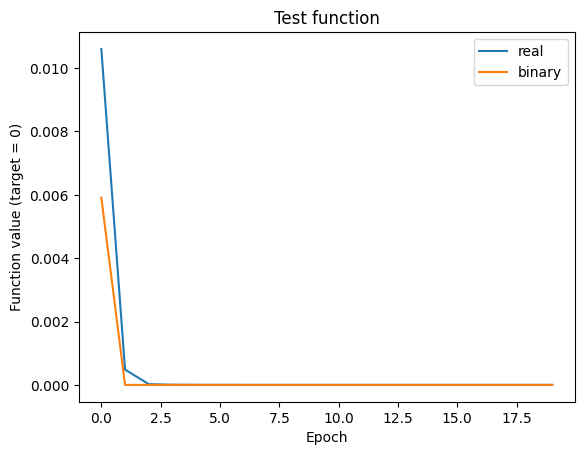

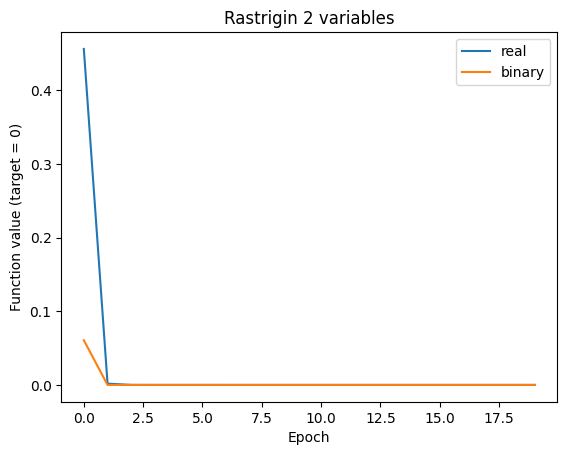

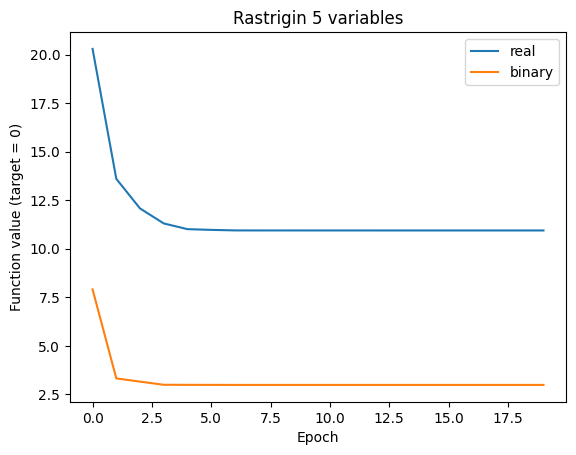

In [27]:
fig1, ax1 = plt.subplots()
ax1.plot(x1)
ax1.plot(y1)
ax1.set_title("Test function")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Function value (target = 0)")
ax1.legend(["real","binary"])

fig2, ax2= plt.subplots() # two axes on figure
ax2.plot(x2)
ax2.plot(y2)
ax2.set_title("Rastrigin 2 variables")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Function value (target = 0)")
ax2.legend(["real","binary"])

fig3, ax3 = plt.subplots() # two axes on figure
ax3.plot(x3)
ax3.plot(y3)
ax3.set_title("Rastrigin 5 variables")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Function value (target = 0)")
ax3.legend(["real","binary"])